# Решение задачи "кластеризация данных с IMU и пульсометра на группы по типу активности"

Набор данных содержит 534601 строк c 53 признаками о мониторинге физической активности.

1. `timestamp` - время измерения
2. `subject_id` - категориальный признак активности

данные с датчиков на руке, груди и лодыжки

**IMU sensory data**:
acc16 - данные акселерометра, scale: Â±16g  
acc6 - данные акселерометра, scale: Â±6g  
gyro - данные гироскопа  
magne - данные магнитометра  
orientation - данные ориентации  

3. `handTemperature` - температура рук  
4-6. `handAcc16_1 - handAcc16_3`  
7-9. `handAcc6_1 - handAcc6_3`  
10-12. `handGyro1 - handGyro3`  
13-15. `handMagne1 - handMagne3`  
16-19. `handOrientation1 - handOrientation4`  

20. `chestTemperature` - темпуратура груди  
21-23. `chestAcc16_1 - chestAcc16_3`  
24-26. `chestAcc6_1 - chestAcc6_3`  
27-29. `chestGyro1 - chestGyro3`  
30-32. `chestMagne1 - chestMagne3`     
33-36. `chestOrientation1 - chestOrientation4`  

37. `ankleTemperature` - температура лодыжки  
38-40. `ankleAcc16_1 - ankleAcc16_3`  
41-43. `ankleAcc6_1 - ankleAcc6_3`  
44-46. `ankleGyro1 - ankleGyro3`              
47-49. `ankleMagne1 - ankleMagne3`  
50-53. `ankleOrientation1 - ankleOrientation4`        a
----
 List of activityIDs and corresponding activities:
1 lying  
2 sitting  
3 standing 
4 walking  
5 running  
6 cycling  
7 Nordic walking  
9 watching TV  
10 computer work  
11 car driving  
12 ascending stairs  
13 descending stairs  
16 vacuum cleaning  
17 ironing  
18 folding laundry  
19 house cleaning  
20 playing soccer  
24 rope jumping  
0	other (transient activities) ng
 0	other (transient activities)

# Установка и импорт библиотек

In [5]:
!pip install numpy pandas seaborn matplotlib --quiet
!pip install scikit-learn yellowbrick --quiet

In [6]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import warnings
warnings.filterwarnings("ignore")

# Считывание данных

In [8]:
X = pd.read_csv("data/physical_activity/Physical_Activity_Monitoring_unlabeled.csv")

In [9]:
X.shape

(534601, 53)

# Исследование и обработка данных

## Первичный обзор

In [12]:
X.head()

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.75,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.5447,27.3336,-5.76620,0.206416,0.348212,0.763201,-0.503652,5
1,3652.45,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.8257,-15.7719,-1.31395,0.578332,-0.566734,0.405888,-0.423791,2
2,504.76,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.8171,16.3089,25.29280,0.139776,0.676586,0.393796,0.606316,8
3,2801.61,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.7418,34.3566,21.32740,0.416303,0.783387,0.306464,0.345075,2
4,441.01,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.7798,-3.9981,10.99500,0.171133,-0.748343,0.252988,-0.588807,6


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534601 entries, 0 to 534600
Data columns (total 53 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   timestamp          534601 non-null  float64
 1   handTemperature    530560 non-null  float64
 2   handAcc16_1        530560 non-null  float64
 3   handAcc16_2        530560 non-null  float64
 4   handAcc16_3        530560 non-null  float64
 5   handAcc6_1         530560 non-null  float64
 6   handAcc6_2         530560 non-null  float64
 7   handAcc6_3         530560 non-null  float64
 8   handGyro1          530560 non-null  float64
 9   handGyro2          530560 non-null  float64
 10  handGyro3          530560 non-null  float64
 11  handMagne1         530560 non-null  float64
 12  handMagne2         530560 non-null  float64
 13  handMagne3         530560 non-null  float64
 14  handOrientation1   530560 non-null  float64
 15  handOrientation2   530560 non-null  float64
 16  ha

Пропусков много. Из плюсов - все данные числовые. Еще хорошо что временная метка(timestamp) проставлена везде.

In [15]:
X.describe()

,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
count,534601.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,530560.000000,...,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,532055.000000,534601.000000
mean,1593.538159,32.451221,-4.435286,3.241949,4.079375,-4.375896,3.218250,4.262513,-0.008852,0.028801,...,-0.031911,0.002304,-28.756284,2.115624,14.723345,0.360159,-0.091093,0.303517,-0.173845,4.558615
std,1243.906483,1.754847,7.062004,7.224031,3.831257,7.068961,6.864782,3.822053,1.160112,0.926832,...,0.618840,2.036102,19.303887,22.253170,17.907491,0.301254,0.559400,0.344271,0.466304,2.318076
min,37.660000,27.500000,-114.755000,-82.550900,-73.949700,-61.214700,-61.824200,-61.577100,-19.690500,-7.609010,...,-7.701040,-14.019600,-172.865000,-136.951000,-102.716000,0.000003,-0.954848,-0.876838,-0.997040,1.000000
25%,475.500000,31.312500,-9.076360,0.682775,1.588777,-8.981072,0.687587,1.780160,-0.153182,-0.083315,...,-0.049003,-0.221911,-39.689950,-10.960850,2.252230,0.145023,-0.676392,0.006839,-0.580040,2.000000
50%,827.610000,32.875000,-5.465610,3.089205,4.157125,-5.434845,3.127145,4.413625,-0.004439,0.004013,...,-0.004481,0.000354,-26.285600,-0.014372,16.599500,0.240996,0.000000,0.322698,-0.281681,5.000000
75%,2876.990000,33.812500,0.383679,5.559742,6.864212,0.424770,5.592180,7.148178,0.130310,0.094342,...,0.048972,0.032649,-14.549500,19.245900,25.947100,0.501671,0.410052,0.594198,0.252247,7.000000
max,4007.730000,35.250000,60.912600,155.532000,78.480100,34.159400,62.259800,60.843700,22.960000,11.862600,...,6.002540,14.482700,41.764800,92.867000,122.521000,1.000000,0.959538,0.920506,0.996105,8.000000


## Удаление неинформативных признаков

In [17]:
class GapsPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        columns_to_delete = [
            # есть точно такие же данные акселерометра только с лучшей точностью: acc6
            'handAcc16_1',
            'handAcc16_2',
            'handAcc16_3',
            'chestAcc16_1',
            'chestAcc16_2',
            'chestAcc16_3',
            'ankleAcc16_1',
            'ankleAcc16_2',
            'ankleAcc16_3',
            # 76% пропусков
            'handTemperature',
            'handAcc6_1',
            'handAcc6_2',
            'handAcc6_3',
            'handGyro1',
            'handGyro2',
            'handGyro3',
            'handMagne1',
            'handMagne2',
            'handMagne3',
            'handOrientation1',
            'handOrientation2',
            'handOrientation3',
            'handOrientation4',
        ]
        X.drop(columns=columns_to_delete, inplace=True)

        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

## Обработка пропусков

In [19]:
def get_missing_stat(df): 
    missing_count = df.isna().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percentage': round(missing_percentage, 2)
    })
    return missing_data[missing_data['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)


get_missing_stat(X)

,Missing Count,Missing Percentage
handTemperature,4041,0.76
handGyro3,4041,0.76
handAcc16_1,4041,0.76
handOrientation3,4041,0.76
handOrientation2,4041,0.76
handOrientation1,4041,0.76
handMagne3,4041,0.76
handMagne2,4041,0.76
handMagne1,4041,0.76
handOrientation4,4041,0.76


Данные с руки считывались хуже всего, получше с лодыжки и еще лучше с груди.

In [21]:
class MissingPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        columns_with_nulls = [
            'ankleGyro2', 'ankleAcc6_1',
            'ankleAcc6_2', 'ankleAcc6_3', 'ankleGyro1', 'ankleMagne2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne3', 'ankleOrientation1', 'ankleOrientation2',
            'ankleOrientation3', 'ankleTemperature',
            'ankleOrientation4', 'chestOrientation4', 'chestAcc6_3',
            'chestTemperature',
            'chestAcc6_1', 'chestAcc6_2', 'chestGyro1', 'chestOrientation3',
            'chestGyro3', 'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2', 'chestGyro2',
        ]
        
        X['original_index'] = X.index
        # поскольку данные представляют собой временной ряд заполним пропуски соседними данными
        X_sorted = X.sort_values(by='timestamp', ascending=True)
        for column in columns_with_nulls:
            rolling_mean = X_sorted[column].rolling(window=3, min_periods=1).mean()
            X_sorted[column] = X_sorted[column].fillna(rolling_mean)
            X_sorted[column].fillna(method='bfill', inplace=True)
        # возвращаем исходную сортировку по требованию к ответу
        X = X_sorted.sort_values(by='original_index').drop(columns='original_index')
        
        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def fill_na(self, group):
        return group.fillna(method='bfill')

## Преобразование данных

In [23]:
class FeaturesPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # измеряют одно и то же по разным осям - применяем метод агрегирования данных,
        # чтобы уменьшить размерность признакового пространства без потери информации
        transform_dict = {
            'chestAcc': ['chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3'],
            'chestGyro': ['chestGyro1', 'chestGyro2', 'chestGyro3'],
            'chestMagne': ['chestMagne1', 'chestMagne2', 'chestMagne3'],
            'chestOrientation': ['chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4'],

            'ankleAcc': ['ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3'],
            'ankleGyro': ['ankleGyro1', 'ankleGyro2', 'ankleGyro3'],
            'ankleMagne': ['ankleMagne1', 'ankleMagne2', 'ankleMagne3'],
            'ankleOrientation': ['ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
        }
        for new_column, old_columns in transform_dict.items():
            X[new_column] = X.apply(lambda row: self.aggregate_axis_data(row, old_columns), axis=1)

        all_old_columns = []
        for values in transform_dict.values():
            all_old_columns.extend(values)
        X.drop(columns=all_old_columns, inplace=True)

        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def aggregate_axis_data(self, row, columns):
        sum_of_squares = sum(row[column]**2 for column in columns)
        return math.sqrt(sum_of_squares) 

## Анализ данных после преобразования

In [25]:
pipeline_preprocessing = Pipeline([
    ('gaps_filter', GapsPreprocessing()),
    ('missing_fill', MissingPreprocessing()),
    ('features_preprocessing', FeaturesPreprocessing()),
])

In [26]:
X_transformed = pipeline_preprocessing.fit_transform(X.copy(deep=True))

In [27]:
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534601 entries, 0 to 534600
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         534601 non-null  float64
 1   chestTemperature  534601 non-null  float64
 2   ankleTemperature  534601 non-null  float64
 3   subject_id        534601 non-null  int64  
 4   chestAcc          534601 non-null  float64
 5   chestGyro         534601 non-null  float64
 6   chestMagne        534601 non-null  float64
 7   chestOrientation  534601 non-null  float64
 8   ankleAcc          534601 non-null  float64
 9   ankleGyro         534601 non-null  float64
 10  ankleMagne        534601 non-null  float64
 11  ankleOrientation  534601 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 53.0 MB


После преобразования удалось уменьшить признаковое пространство

In [29]:
X_transformed.head()

,timestamp,chestTemperature,ankleTemperature,subject_id,chestAcc,chestGyro,chestMagne,chestOrientation,ankleAcc,ankleGyro,ankleMagne,ankleOrientation
0,252.75,36.6250,34.1250,5,9.877675,0.039630,48.756258,1.0,9.819462,0.059178,31.494810,1.0
1,3652.45,34.6875,33.6250,2,11.229790,0.475300,43.098251,1.0,8.182519,1.934298,36.441815,1.0
2,504.76,37.6250,33.9375,8,9.797023,0.041782,26.697400,1.0,9.828768,0.066698,35.493509,1.0
3,2801.61,36.5000,34.5625,2,13.233767,0.504263,39.066927,1.0,18.410660,4.589847,48.480489,1.0
4,441.01,35.8125,34.6875,6,9.851332,0.063361,26.316878,1.0,9.869706,0.031659,21.283705,1.0


In [30]:
X_transformed.describe()

,timestamp,chestTemperature,ankleTemperature,subject_id,chestAcc,chestGyro,chestMagne,chestOrientation,ankleAcc,ankleGyro,ankleMagne,ankleOrientation
count,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000,534601.000000
mean,1593.538159,35.870190,33.493317,4.558615,10.091763,0.416316,42.670043,0.999836,12.016159,1.284203,43.695172,0.999231
std,1243.906483,1.504372,1.082615,2.318076,3.350916,0.594054,13.961384,0.007191,6.603232,1.950945,18.083968,0.018493
min,37.660000,32.062500,30.000000,1.000000,0.127027,0.000448,12.243470,0.258368,0.080547,0.000589,4.723596,0.012203
25%,475.500000,34.687500,32.750000,2.000000,9.669734,0.049297,31.677144,1.000000,9.825099,0.039943,31.825691,1.000000
50%,827.610000,35.937500,33.812500,5.000000,9.831831,0.197989,41.957018,1.000000,9.877115,0.157363,43.096686,1.000000
75%,2876.990000,37.187500,34.375000,7.000000,10.052289,0.552875,48.686462,1.000000,11.216982,1.840849,50.141352,1.000000
max,4007.730000,38.437500,35.000000,8.000000,57.611265,11.532051,125.807338,1.000001,89.092226,15.399451,184.989082,1.000001


## Проверка линейных зависимостей в данных

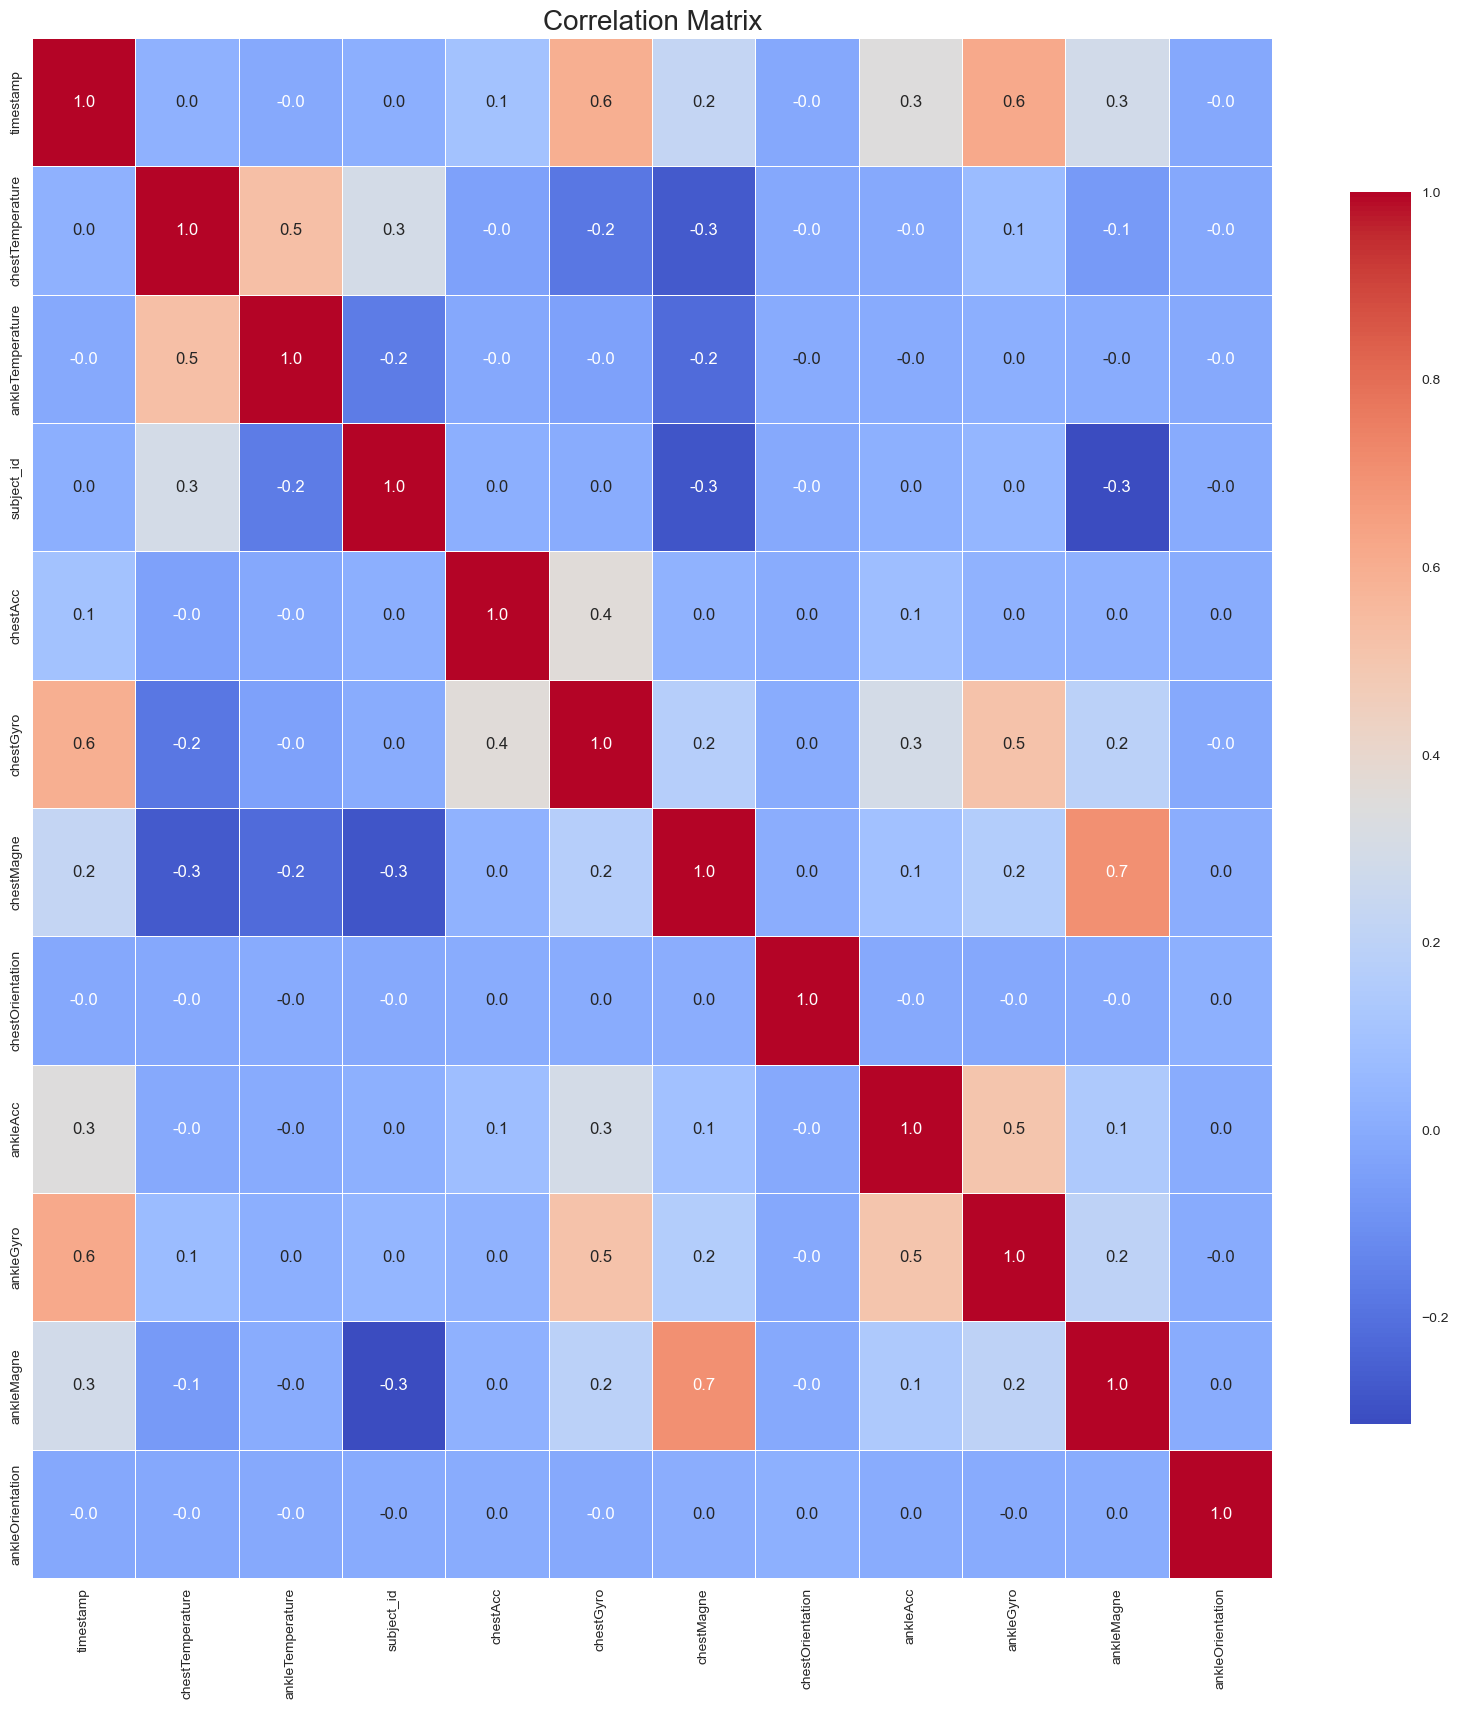

In [32]:
corr_matrix = X_transformed.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".1f", 
            linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', size=20)
plt.show()

In [33]:
X_transformed['timestamp'].nunique()

215964

In [54]:
class GapsPostprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # chestMagne коррелирует с ankleMagne на 0.7. ankleMagne изначально был заполнен лучше, поэтому оставим его
        # timestamp наполовину уникальная колонка
        # но, как показал эксперемент, лучше ничего не удалять
        # этот класс оставлен для эксперементов, чтобы выполнить вторую итерацию обработки данных
        X.drop(columns=['chestOrientation', 'ankleOrientation', 'chestGyro', 'chestMagne', 'ankleGyro', 'ankleMagne'], inplace=True)
        X.drop(columns=['chestTemperature', 'ankleTemperature'], inplace=True)
        # X.drop(columns=['timestamp', 'subject_id'], inplace=True)
        

        return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

# Эксперемент с выбором модели

In [56]:
# данных очень много подбирать параметры моделей будем на части данных
# 5% = 26730 записей
train_size = 0.1

pipeline_processing = Pipeline([
    ('preprocessing', pipeline_preprocessing),
    ('gaps_postprocessing', GapsPostprocessing()),
])

 ## KMeans

In [58]:
X_transformed = pipeline_processing.fit_transform(X.copy(deep=True))
X_train, _ = train_test_split(X_transformed, train_size=train_size, random_state=42)

In [59]:
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534601 entries, 0 to 534600
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   timestamp   534601 non-null  float64
 1   subject_id  534601 non-null  int64  
 2   chestAcc    534601 non-null  float64
 3   ankleAcc    534601 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 20.4 MB


### Подбор количества кластеров

Подберем методом локтя примерное количество необходимых кластеров.

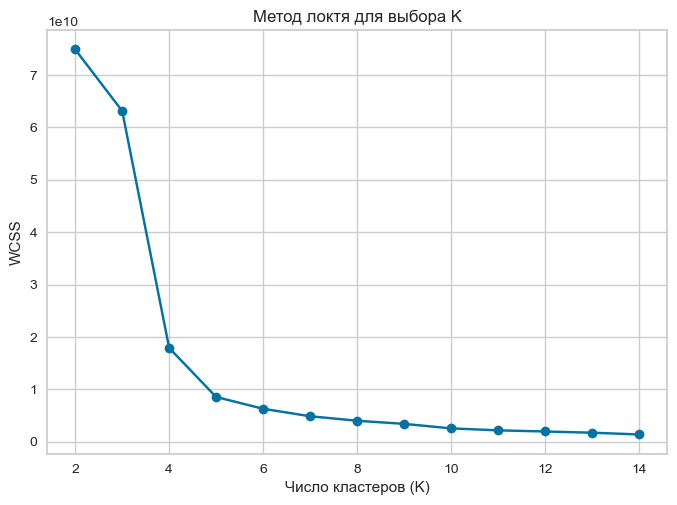

In [41]:
wcss = []
K_values = range(2, 15)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    # здесь вычисления недолгие, можно и на всем наборе данных
    kmeans.fit(X_transformed)
    wcss.append(kmeans.inertia_)

plt.plot(K_values, wcss, marker='o', linestyle='-')
plt.xlabel("Число кластеров (K)")
plt.ylabel("WCSS")
plt.title("Метод локтя для выбора K")
plt.show()

Уточним методом силуэта количество кластеров

calculate 3 clusters...
calculate 4 clusters...
calculate 5 clusters...
calculate 6 clusters...
calculate 7 clusters...
calculate 8 clusters...
calculate 9 clusters...


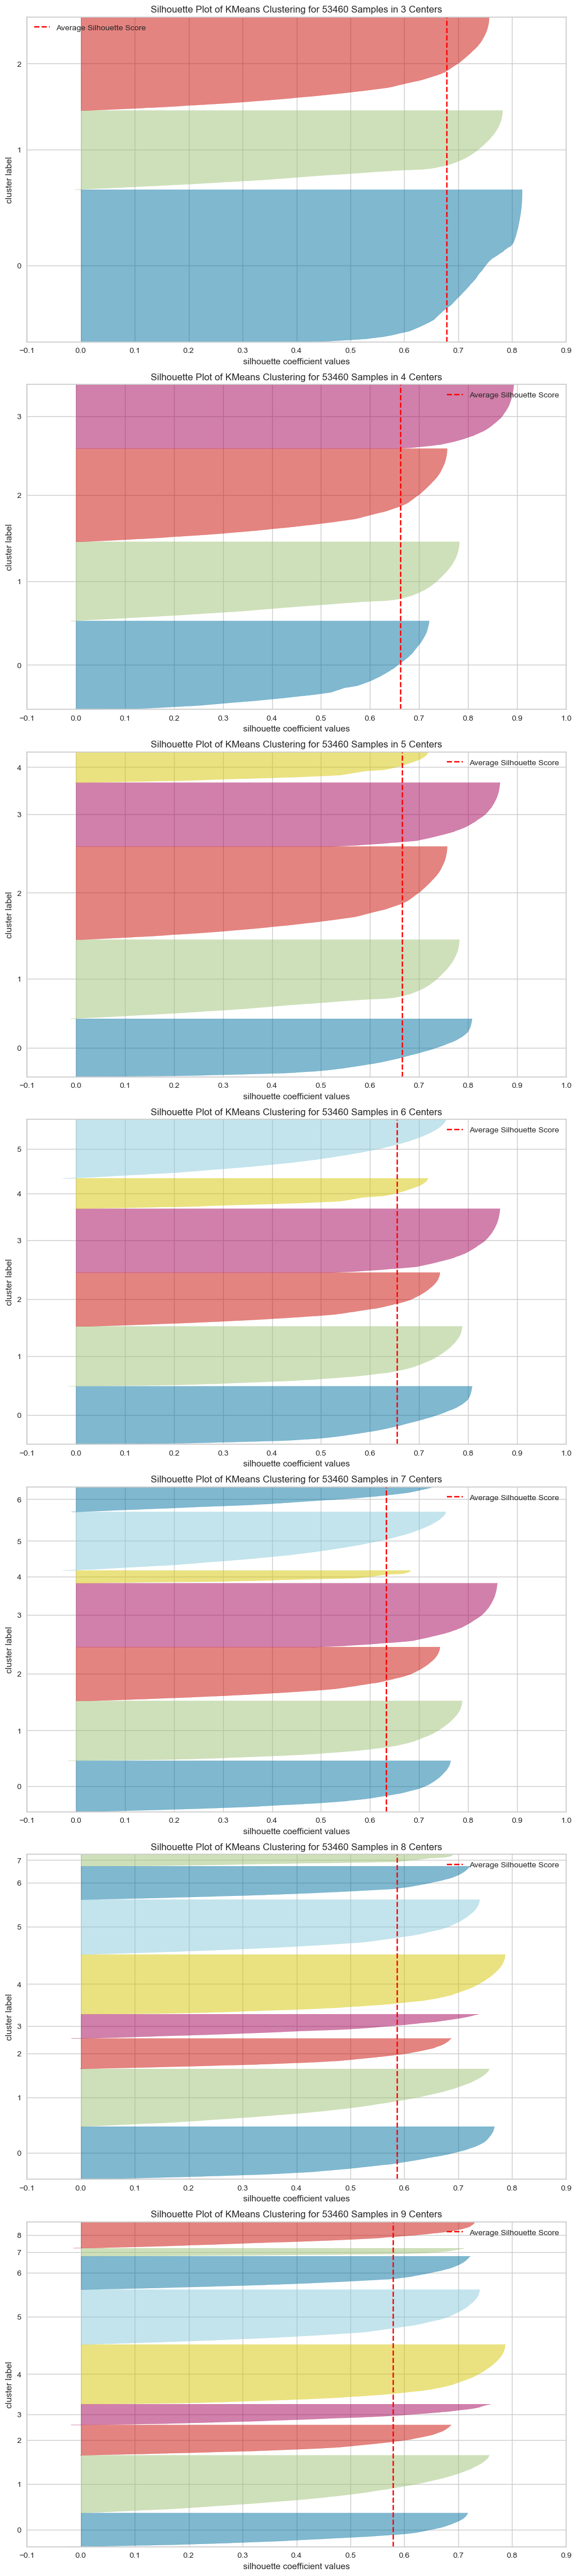

In [43]:
range_n_clusters = range(3, 8)
fig = plt.figure(constrained_layout=True, figsize=(10, 45))
gs = GridSpec(len(range_n_clusters), 1, figure=fig)

for idx, n_clusters in enumerate(range_n_clusters):
    print(f'calculate {n_clusters} clusters...')
    ax = fig.add_subplot(gs[idx, 0])
    model = KMeans(n_clusters=n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(model, ax=ax, colors='yellowbrick')

    visualizer.fit(X_train)
    visualizer.finalize()

plt.show()

In [62]:
for k in range(3, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=600)
    clusters_kmean = kmeans.fit_predict(X_train)
    score = silhouette_score(X_train, clusters_kmean)
    print(f'Score KMeans {k} clusters: {score}')

Score KMeans 3 clusters: 0.6786760845260462
Score KMeans 4 clusters: 0.6626771568841474
Score KMeans 5 clusters: 0.6663190311264033
Score KMeans 6 clusters: 0.6559096532605041
Score KMeans 7 clusters: 0.6339199270950182


### Рассчет

In [46]:
n_clusters = 7
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans_model.fit_predict(X_transformed)
X_transformed['activityID'] = pd.factorize(cluster_labels)[0] + 1

In [47]:
submition = pd.DataFrame(X_transformed, columns=['activityID'])
submition = submition.reset_index()
submition.to_csv('kmeans-submition.csv', index=False);

## DBSCAN

In [49]:
X_transformed = pipeline_processing.fit_transform(X.copy(deep=True))
X_train, _ = train_test_split(X_transformed, train_size=train_size, random_state=42)

In [50]:
# Диапазоны гиперпараметров для подбора
eps_range = np.arange(0.1, 2.5, 0.5)
min_samples_range = range(2, 20, 4)

# Переменные для хранения лучших параметров и метрики
best_score = -1
best_params = None

# Поиск по сетке
for eps in eps_range:
    for min_samples in min_samples_range:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(X_train)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X_train, labels)
            print(f'eps {eps:.2f} min_samples {min_samples} score: {score:.2f}')
            
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Лучшие параметры: {best_params}")
print(f"Лучший силуэтный коэффициент: {best_score:.2f}")

eps 0.10 min_samples 2 score: -0.66
eps 0.10 min_samples 4 score: -0.93
eps 0.10 min_samples 6 score: -0.34
eps 0.20 min_samples 2 score: -0.36
eps 0.20 min_samples 4 score: -0.71
eps 0.20 min_samples 6 score: -0.90
eps 0.20 min_samples 8 score: -0.40
eps 0.30 min_samples 2 score: -0.23
eps 0.30 min_samples 4 score: -0.46
eps 0.30 min_samples 6 score: -0.76
eps 0.30 min_samples 8 score: -0.79
eps 0.30 min_samples 10 score: -0.40
eps 0.40 min_samples 2 score: -0.20
eps 0.40 min_samples 4 score: -0.32
eps 0.40 min_samples 6 score: -0.56
eps 0.40 min_samples 8 score: -0.81
eps 0.40 min_samples 10 score: -0.80
eps 0.40 min_samples 12 score: -0.39
eps 0.40 min_samples 14 score: -0.29


KeyboardInterrupt: 

### Рассчет

In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples=18)
cluster_labels = dbscan.fit_predict(X_transformed)
X_transformed['activityID'] = pd.factorize(cluster_labels)[0] + 1

In [ ]:
submition = pd.DataFrame(X_transformed, columns=['activityID'])
submition = submition.reset_index()
submition.to_csv('dbscan-submition.csv', index=False);

# Результат

Наилучший результат - использование KMeans с 3 кластерами. Итоговый score 0.44990
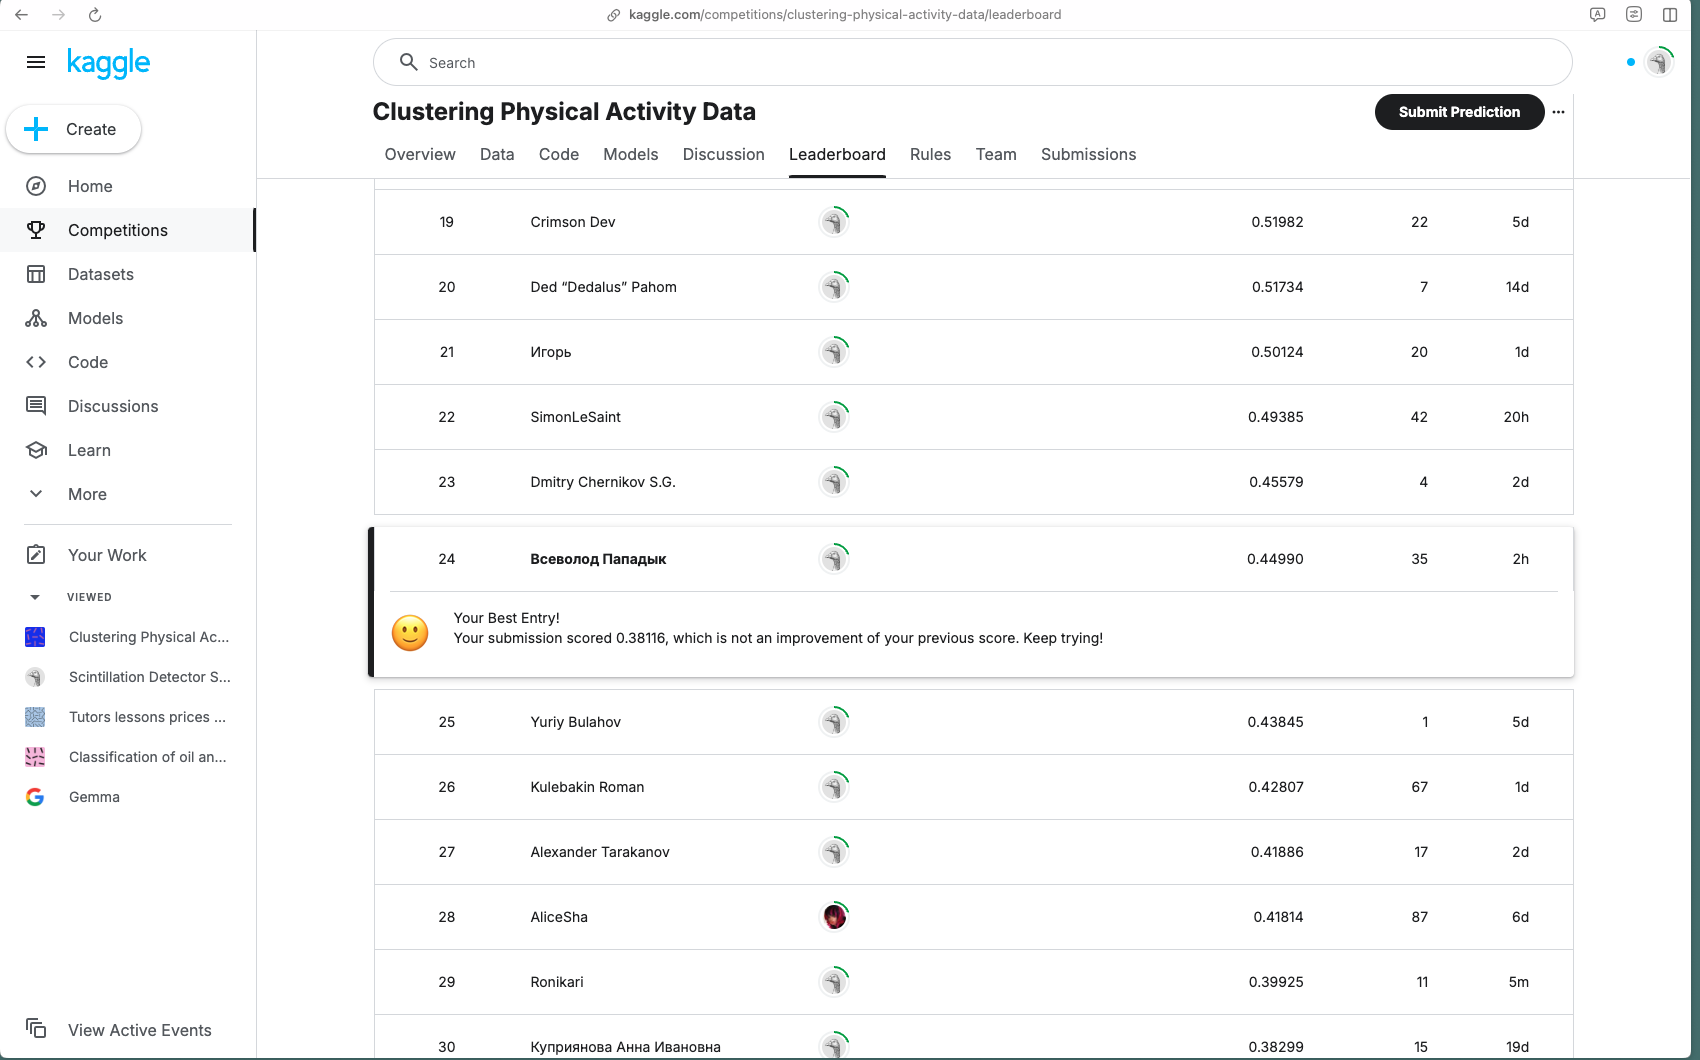